In [303]:
import numpy as np
import pandas as pd
import obonet
import pubchempy as pcp
import sys
import random
from project_classifiers import *
import matplotlib.pyplot as plt

In [8]:
url = 'https://ftp.ebi.ac.uk/pub/databases/chebi/ontology/chebi_lite.obo'
graph = obonet.read_obo(url)

In [13]:
id_to_rel = {id_: data.get('relationship') for id_, data in graph.nodes(data=True)}
print(id_to_rel['CHEBI:26710'])
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
print(id_to_name['CHEBI:26710'])
id_to_is_a = {id_: data.get('is_a') for id_, data in graph.nodes(data=True)}
print(id_to_is_a['CHEBI:95093'])

['has_role CHEBI:149552', 'has_role CHEBI:79314']
sodium chloride
['CHEBI:26513', 'CHEBI:38582', 'CHEBI:35358', 'CHEBI:35618', 'CHEBI:26421', 'CHEBI:37921']


In [10]:
structs = pd.read_csv('structures_3star.csv.gz')
#sstr = structs[structs['TYPE'] == 'SMILES'].to_numpy()
#print(smiles)
display(structs)

,ID,COMPOUND_ID,STRUCTURE,TYPE,DIMENSION,DEFAULT_STRUCTURE,AUTOGEN_STRUCTURE
0,543,16440,\n Marvin 05200702402D \n\n 11 10 ...,mol,2D,Y,N
1,544,16444,ChEBI\n Marvin 09080515022D \n\n 9...,mol,2D,Y,N
2,546,16450,ChEBI\n Marvin 02091110562D \n\n 16...,mol,2D,Y,N
3,547,16453,ChEBI\n Marvin 04230816342D \n\n 10...,mol,2D,Y,N
4,549,16468,\n Marvin 11230613582D \n\n 11 10 ...,mol,2D,Y,N
...,...,...,...,...,...,...,...
401815,3336071,197372,InChI=1S/C14H30O/c1-3-5-7-8-9-10-11-13-14(15)1...,InChI,1D,N,Y
401816,3336076,197373,KATMMOGJSFLTOP-UHFFFAOYSA-N,InChIKey,1D,N,Y
401817,3336075,197373,\n Ketcher 09272313312D 1 1.00000 0.000...,mol,2D,Y,N
401818,3336077,197373,InChI=1S/C14H30O/c1-3-5-7-8-9-11-13-14(15)12-1...,InChI,1D,N,Y


In [250]:
structs_default = structs[(structs['DEFAULT_STRUCTURE'] == 'Y')].to_numpy()
print(structs_default.shape[0])

103696


In [290]:
has_role = []
role = input()

for i in range(structs_default.shape[0]):
    chebi_id = 'CHEBI:' + str(structs_default[i][1])
    relations = id_to_rel[chebi_id]
    is_a = id_to_is_a[chebi_id]
    if relations:
        for rel in relations:
            if 'has_role CHEBI:' + role in rel:
                has_role.append(i)
    elif is_a:
        if 'CHEBI:' + role in is_a:
            has_role.append(i)
        
print(len(has_role))
structs_role = structs_default[has_role]

print(structs_role.shape)

if structs_role.shape[0] > 100:
    indices = random.sample(range(0, structs_role.shape[0]), 100)
    structs_role = structs_role[indices]
    
structs_role = np.append(structs_role, [[1]]*structs_role.shape[0], axis=1)

print(structs_role.shape)

 37958


108
(108, 7)
(100, 8)


In [291]:
structs_not_role = np.delete(structs_default, has_role, axis=0)
print(structs_not_role.shape)

indices = random.sample(range(0, structs_not_role.shape[0]), structs_role.shape[0])

structs_chosen = structs_not_role[indices]
structs_chosen = np.append(structs_chosen, [[0]]*structs_chosen.shape[0], axis=1)

print(structs_chosen.shape)

(103588, 7)
(100, 8)


In [292]:
structs_all = np.append(structs_role, structs_chosen, axis=0)
print(structs_all.shape)

(200, 8)


In [293]:
mols = []
not_in_pcp = []

for i in range(structs_all.shape[0]):
    try:
        chebi_id = 'CHEBI:' + str(structs_all[i][1])
        name = id_to_name[chebi_id]
        pubchem_compound = pcp.get_compounds(name, 'name')[0]
        fingerprint = np.asarray([int(bit) for bit in pubchem_compound.cactvs_fingerprint])
        #print(fingerprint)
        mols.append(fingerprint)
    except IndexError:
        not_in_pcp.append(i)

In [294]:
print(len(not_in_pcp))
structs_new = np.delete(structs_all, not_in_pcp, axis=0)
print(structs_new.shape)
mols = np.array(mols)

23
(177, 8)


In [295]:
labels = structs_new[:, structs_new.shape[1] - 1]
print(labels)
print(len(labels))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
177


In [296]:
test_indices = random.sample(range(0, mols.shape[0] - 1), mols.shape[0] // 5)

print(test_indices)
mols_test = mols[test_indices]
mols_train = np.delete(mols, test_indices, axis=0)

print(mols_test.shape)
print(mols_train.shape)

labels_test = labels[test_indices]
labels_train = np.delete(labels, test_indices, axis=0)

print(labels_test.shape)
print(labels_test)
print(labels_train.shape)
print(labels_train)

[53, 149, 55, 157, 135, 89, 120, 87, 136, 14, 174, 102, 118, 168, 63, 150, 15, 160, 39, 128, 170, 138, 3, 52, 9, 126, 49, 113, 62, 24, 67, 158, 51, 167, 4]
(35, 881)
(142, 881)
(35,)
[1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1]
(142,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [297]:
train = np.append(mols_train, [[label] for label in labels_train], axis=1)
test = np.append(mols_test, [[label] for label in labels_test], axis=1)
print(train.shape)
print(test.shape)

(142, 882)
(35, 882)


In [298]:
header = np.arange(0, train.shape[1] - 1)
header = np.append(header, ['Label'])

In [299]:
training_set = pd.DataFrame(train, columns=header)
display(training_set)

testing_set = pd.DataFrame(test, columns=header)
display(testing_set)

training_data_loc = 'project\\data\\project_dye-train.csv'
testing_data_loc = 'project\\data\\project_dye-test.csv'

training_set.to_csv(training_data_loc, index=False)
testing_set.to_csv(testing_data_loc, index=False)

,0,1,2,3,4,5,6,7,8,9,...,872,873,874,875,876,877,878,879,880,Label
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
138,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
139,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
140,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,...,872,873,874,875,876,877,878,879,880,Label
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
8,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [71]:
training_data_loc = 'project\\data\\project_organic_molecular_entity-train.csv'
testing_data_loc = 'project\\data\\project_organic_molecular_entity-test.csv'

In [300]:
nb = NaiveBayes(training_data_loc, testing_data_loc, [])
nb.get_predictions()

Labels:  [1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1]
Predictions:  [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1]
Accuracy:  0.9142857142857143


In [301]:
lr = LogReg(training_data_loc, testing_data_loc, [], 0.01, 1000)
lr.grad_ascent()
lr.get_predictions()

Labels:  [1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1]
Predictions:  [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1]
Accuracy:  1.0


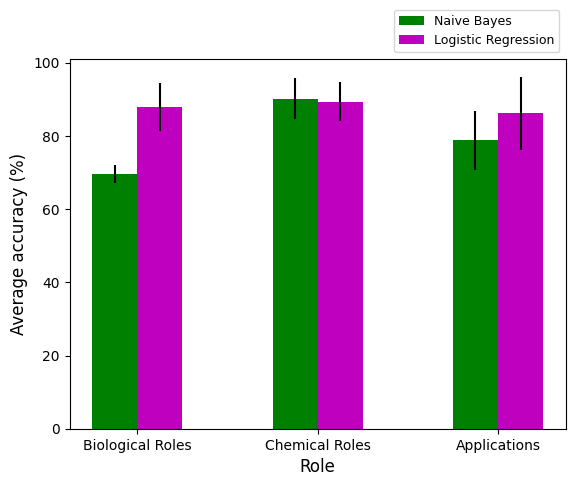

In [357]:
accuracies = pd.read_csv('project\\data\\cs109_project_accuracies.csv')
#display(accuracies)

bio_roles = accuracies[accuracies['Superrole'] == 'biological role']
chem_roles = accuracies[accuracies['Superrole'] == 'chemical role']
app_roles = accuracies[accuracies['Superrole'] == 'application']

#display(bio_roles)
#display(chem_roles)
#display(app_roles)

roles = [bio_roles, chem_roles, app_roles]
roles_names = ['Biological Roles', 'Chemical Roles', 'Applications']

nb_means = []
lr_means = []

for role in roles:
    nb_means.append(np.mean(role['Naive Bayes Accuracy']))
    lr_means.append(np.mean(role['Logistic Regression Accuracy']))

nb_stds = []
lr_stds = []

for i in range(len(roles)):
    role = roles[i]
    var_nb = 0
    x_nb = role['Naive Bayes Accuracy']
    n_nb = len(x_nb)
    for x in x_nb:
        var_nb += (x - nb_means[i])**2
    var_nb *= (1 / (n_nb - 1))
    nb_stds.append(np.sqrt(var_nb / n_nb))

    var_lr = 0
    x_lr = role['Logistic Regression Accuracy']
    n_lr = len(x_lr)
    for x in x_lr:
        var_lr += (x - lr_means[i])**2
    var_lr *= (1 / (n_lr - 1))
    lr_stds.append(np.sqrt(var_lr / n_lr))


bar_width = 0.25
#fig = plt.subplots(figsize =(12, 8)) 
 
# Set position of bar on X axis 
nb_bar = np.arange(len(nb_means))
lr_bar = [x + bar_width for x in br1]

plt.bar(nb_bar, [mean * 100 for mean in nb_means], color='g', width=bar_width, yerr=[std * 100 for std in nb_stds])
plt.bar(lr_bar, [mean * 100 for mean in lr_means], color='m', width=bar_width, yerr=[std * 100 for std in lr_stds])

plt.xticks([x + 0.5*bar_width for x in range(len(nb_means))], roles_names)
plt.xlabel('Role', fontsize=12) 
plt.ylabel('Average accuracy (%)', fontsize=12) 
plt.legend(['Naive Bayes', 'Logistic Regression'], fontsize=9, loc='upper right', bbox_to_anchor=(1.0, 1.15))

plt.savefig('project\\data\\average_accuracy_plot.png')